In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import DBSCAN
import plotly.graph_objs as go
import plotly.offline as pyoff
from sklearn.decomposition import FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
#pd.options.display.max_rows = 40000
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
data = pd.read_excel(url)
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [ ]:
print(data.nunique())
print(data.isnull().sum())

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
data.UnitPrice.value_counts(normalize=False)

1.25      50496
1.65      38181
0.85      28497
2.95      27768
0.42      24533
          ...  
84.21         1
46.86         1
28.66         1
156.45        1
224.69        1
Name: UnitPrice, Length: 1630, dtype: int64

In [3]:
data['expensive'] = data['UnitPrice'].apply(lambda x: 1 if x > 10 else 0)
data['intermediate'] = data['UnitPrice'].apply(lambda x: 1 if (x > 5 and x<10) else 0)
print(data.expensive.value_counts(normalize = False))
print(data.intermediate.value_counts(normalize = False))

0    516890
1     25019
Name: expensive, dtype: int64
0    478955
1     62954
Name: intermediate, dtype: int64


In [4]:
print(data.describe())

            Quantity      UnitPrice     CustomerID      expensive  \
count  541909.000000  541909.000000  406829.000000  541909.000000   
mean        9.552250       4.611114   15287.690570       0.046168   
std       218.081158      96.759853    1713.600303       0.209850   
min    -80995.000000  -11062.060000   12346.000000       0.000000   
25%         1.000000       1.250000   13953.000000       0.000000   
50%         3.000000       2.080000   15152.000000       0.000000   
75%        10.000000       4.130000   16791.000000       0.000000   
max     80995.000000   38970.000000   18287.000000       1.000000   

        intermediate  
count  541909.000000  
mean        0.116171  
std         0.320430  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  


In [5]:
from datetime import datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])                                           #Here, to check no of customers on weekdays and weekends, we create a new 
data['Day'] = data['InvoiceDate'].apply(lambda x: datetime.strftime(x, '%A'))                       #column 'Day'.


Thursday     103857
Tuesday      101808
Monday        95111
Wednesday     94565
Friday        82193
Sunday        64375
Name: Day, dtype: int64


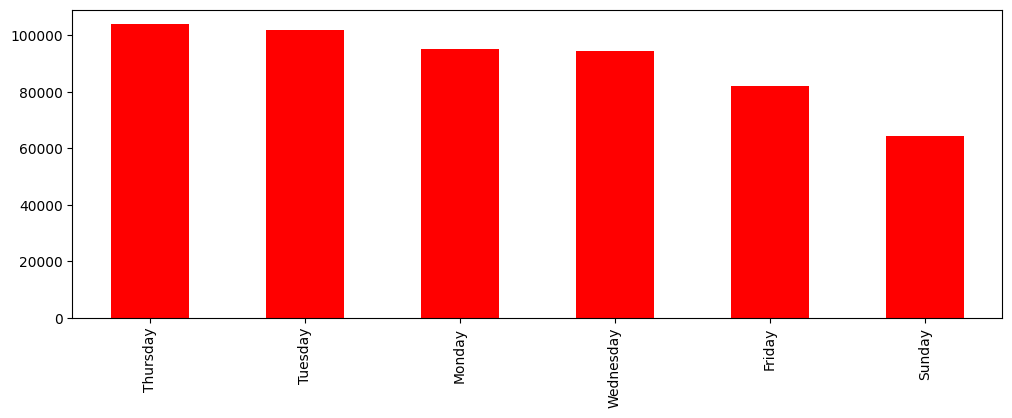

In [5]:
import matplotlib.pyplot as plt       
fig = plt.figure(figsize=(12,4))     
data.Day.value_counts().plot(kind="bar",alpha=1,color = 'red')        #This shows that no shopping happened on Saturday
print(data.Day.value_counts())

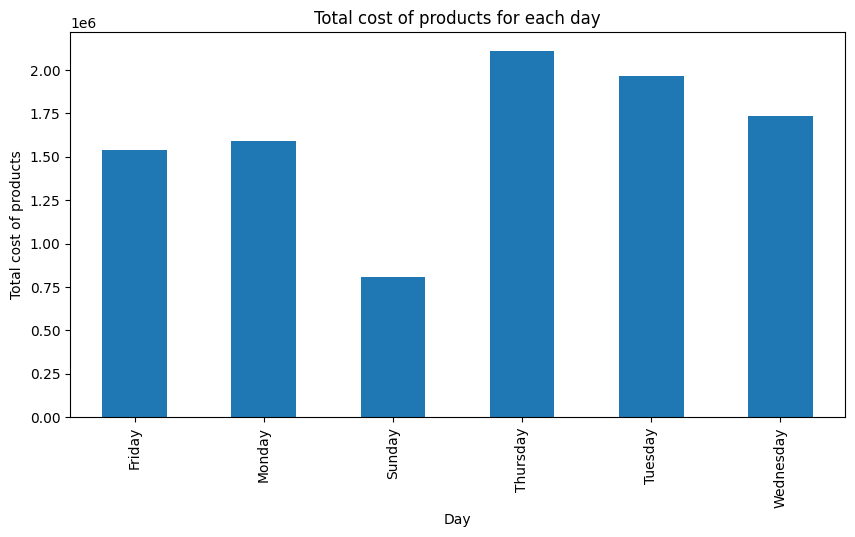

In [5]:
data['TotalCost'] = data['Quantity']*data['UnitPrice']
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
weekday_total = data.groupby(data['InvoiceDate'].dt.strftime('%A'))['TotalCost'].sum()
weekday_total.plot(kind='bar', figsize=(10,5))
plt.title('Total cost of products for each day')
plt.xlabel('Day')
plt.ylabel('Total cost of products')
plt.show()

In [14]:

data['InvoiceYearMonth'] = data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
TotalCost = data.groupby(['InvoiceYearMonth'])['TotalCost'].sum().reset_index()
#X and Y axis inputs for Plotly graph. We use Scatter for line graphs
plot_data = [
    go.Scatter(
        x=TotalCost['InvoiceYearMonth'],
        y=TotalCost['TotalCost'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [6]:
# Remove missing values
data = data.dropna()

# Encode categorical variables
encoder = LabelEncoder()
data['Country'] = encoder.fit_transform(data['Country'])

# Extract features and target variable
X = data.drop(['CustomerID', 'InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'Country','expensive','intermediate','Day'], axis=1) #i.e applied UnitPrice,Quantity
y = data['CustomerID']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<ipython-input-6-a1081dd07269>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# Dimensionality reduction
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get the explained variance ratio
variance_ratio = pca.explained_variance_ratio_

# Calculate the total variance retained
total_variance_retained = np.sum(variance_ratio)

# Print the results
print("Explained variance ratio: ", variance_ratio)
print("Total variance retained: ", total_variance_retained)
# # ICA
# ica = FastICA(n_components=2)
# X_ica = ica.fit_transform(X_scaled)
# # Get the explained variance
# variance = ica.explained_variance_ratio_

# # Calculate the total variance retained
# total_variance_retained = np.sum(variance)

# # Print the results
# print("Explained variance: ", variance)
# print("Total variance retained: ", total_variance_retained)


Explained variance ratio:  [0.64178248 0.33321915]
Total variance retained:  0.9750016332680658
[[ 0.02418957 -0.01642782]
 [ 0.01706429 -0.00441303]
 [ 0.00776831 -0.01242672]
 ...
 [ 0.0299723   0.00530864]
 [ 0.0299723   0.00530864]
 [ 0.03683216  0.01616966]]


In [17]:
# Clustering
# K-Means
kmeans = KMeans(n_clusters=4, random_state=42,n_init = 1)
kmeans.fit(X_pca)
y_pred_pca_km = kmeans.predict(X_pca)
# Performance Evaluation
# Silhouette Score
print('Silhouette Score for PCA K-Means:', silhouette_score(X_pca, kmeans.labels_))


KeyboardInterrupt: ignored

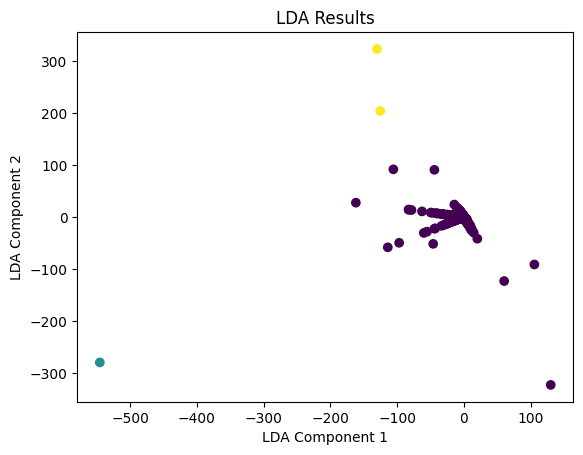

In [13]:
# assuming X is the preprocessed data and y is the target variable
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)
kmeans = KMeans(n_clusters=3, random_state=42,n_init = 1)
kmeans.fit(X_lda)
y_pred_lda_km = kmeans.predict(X_lda)

# Plot the results
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_pred_lda_km)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Results')
plt.show()

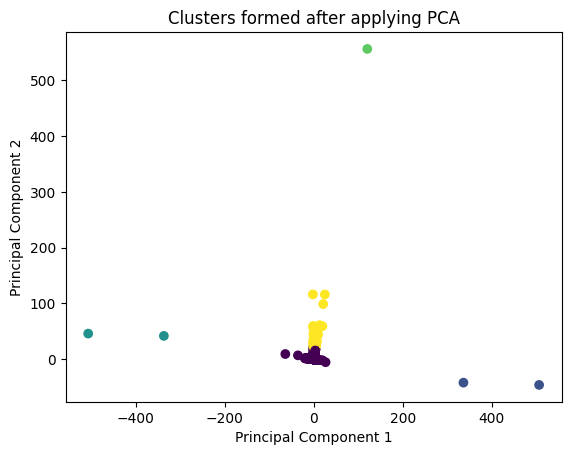

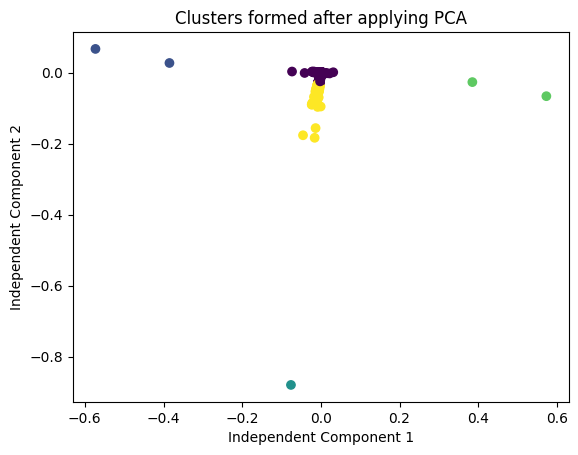

In [ ]:
# Plotting clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_pca_km)
plt.title('Clusters formed after applying PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



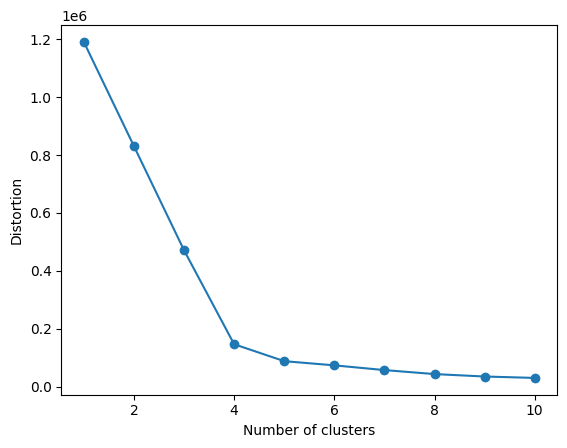

In [ ]:
# Elbow Method
# K-Means with PCA
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, random_state=42,n_init = 1)
    km.fit(X_pca)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [11]:
# KNN Classification
# KNN with PCA
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_pca, y)
y_pred_pca_knn = knn.predict(X_pca)


In [ ]:
# Creating KNN graph
knn_graph = kneighbors_graph(X, n_neighbors=100)

# Plotting KNN graph
plt.spy(knn_graph, markersize=1)
plt.title('KNN graph')
plt.xlabel('Sample index')
plt.ylabel('Sample index')
plt.show()

In [ ]:
 # Splitting data into training and testing sets
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # # Random Forest
# # rf = RandomForestClassifier(n_estimators=100, random_state=42)
# # rf.fit(X_train, y_train)
# # print('Accuracy of Random Forest:', rf.score(X_test, y_test))

# Support Vector Machines
svm = SVC(kernel='rbf', C=10, gamma=0.1)
svm.fit(X_train, y_train)
print('Accuracy of SVM:', svm.score(X_test, y_test))